<h1> 버스 운행시간 예측

# 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdriv')
data_path = "/content/gdriv/My Drive/Colab Notebooks/study/data" 

import folium
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Mounted at /content/gdriv


In [2]:
# 한글 표시 코드

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (49.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155332 files and di

In [3]:
train = pd.read_csv(data_path + '/train.csv')
test = pd.read_csv(data_path + '/test.csv')
submission = pd.read_csv(data_path + '/submission_제출양식.csv')
rain = pd.read_csv(data_path + '/rain.csv', encoding='cp949')

# 데이터 분석

+ id : 고유 id
+ date : 버스 운행 날짜
+ route_id : 버스 노선 ID
+ vh_id : 버스 id
+ route_nm : 버스 노선 실제 번호 -> route_id 와 비슷한 역할
+ now_latitude : 현재 정류소의 위도
+ now_longitude : 현재 정류소의 경도
+ now_station : 현재 정류소 이름
+ now_arrive_time : 현재 정류장에 도착한 시간
+ distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
+ next_station : 다음 정류소 이름
+ next_latitude : 다음 정류소의 위도
+ next_longitude : 다음 정류소의 경도
+ next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값

In [4]:
train.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [5]:
test.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude
0,210457,2019-10-29,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353
1,210458,2019-10-29,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624
2,210459,2019-10-29,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350
3,210460,2019-10-29,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933
4,210461,2019-10-29,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [7]:
train.describe()

,id,route_id,vh_id,now_latitude,now_longitude,distance,next_latitude,next_longitude,next_arrive_time
count,210457.000000,2.104570e+05,2.104570e+05,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000
mean,105228.000000,4.052491e+08,7.988694e+06,33.434528,126.603451,490.256100,33.434711,126.603687,85.380824
std,60753.847139,9.132404e+04,6.774077e+03,0.102350,0.123961,520.563932,0.102224,0.123838,85.051170
min,0.000000,4.051360e+08,7.983000e+06,33.244382,126.473300,97.000000,33.244382,126.473300,6.000000
25%,52614.000000,4.051365e+08,7.983093e+06,33.325283,126.523900,291.000000,33.325283,126.524550,44.000000
50%,105228.000000,4.053201e+08,7.983431e+06,33.484667,126.551050,384.000000,33.484860,126.551050,66.000000
75%,157842.000000,4.053201e+08,7.997041e+06,33.500197,126.650322,542.000000,33.500228,126.650322,102.000000
max,210456.000000,4.053281e+08,7.997124e+06,33.556167,126.935188,7461.000000,33.556167,126.935188,2996.000000


(array([1.96182e+05, 8.41900e+03, 4.27400e+03, 9.70000e+01, 8.90000e+01,
        8.08000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.88000e+02]),
 array([  97. ,  833.4, 1569.8, 2306.2, 3042.6, 3779. , 4515.4, 5251.8,
        5988.2, 6724.6, 7461. ]),
 <a list of 10 Patch objects>)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


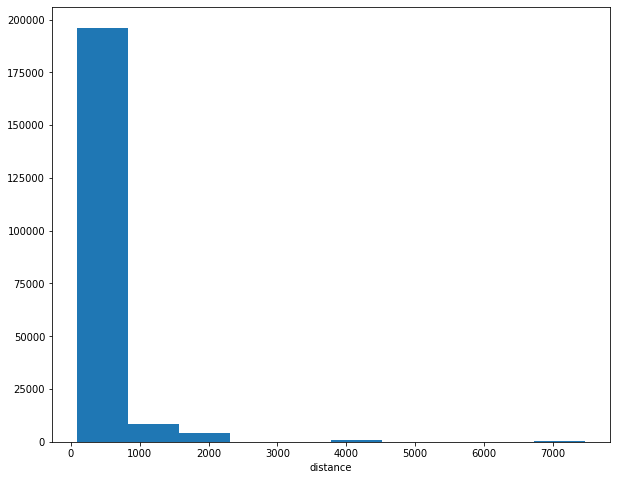

In [8]:
distance = train['distance']
plt.figure(figsize=(10,8))
plt.xlabel('distance')
plt.hist(distance)

(array([21990., 27538., 25535., 25789., 26566., 26262., 23082., 26279.,
         6957.,   459.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)


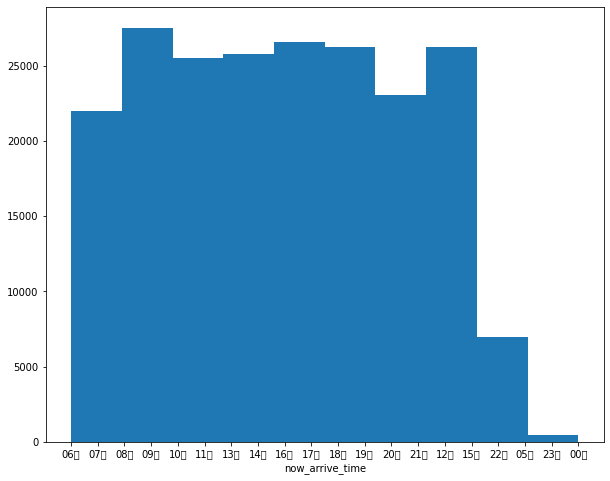

In [9]:
# 현재 정류장 도착한 시간 분포 확인
times = train['now_arrive_time']
plt.figure(figsize=(10,8))
plt.xlabel('now_arrive_time')
plt.hist(times)

- 01~04시 데이터 존재하지 않음 -> 나중에 시간대를 고려할 때 '새벽' 변수는 추가하지 않아도 될 것 같음

(array([2.07537e+05, 2.48600e+03, 2.08000e+02, 7.30000e+01, 3.70000e+01,
        3.40000e+01, 2.00000e+01, 3.00000e+01, 1.60000e+01, 1.60000e+01]),
 array([   6.,  305.,  604.,  903., 1202., 1501., 1800., 2099., 2398.,
        2697., 2996.]),
 <a list of 10 Patch objects>)

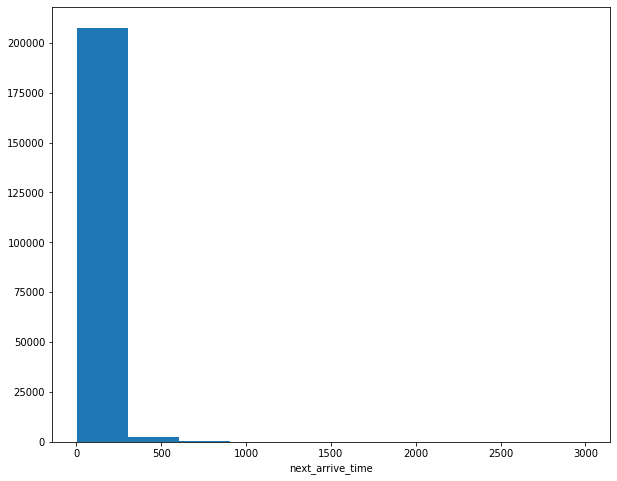

In [10]:
# 예측 시간 분포 확인
target = train['next_arrive_time']
plt.figure(figsize=(10,8))
plt.xlabel('next_arrive_time')
plt.hist(target)

- 다수의 데이터가 0~200 사이에 존재함 -> 1000보다 큰 경우는 삭제..?

In [11]:
train[['route_id', 'next_arrive_time']].groupby('route_id').mean()

,next_arrive_time
route_id,
405136001,92.063688
405136002,108.270852
405136007,94.172947
405136012,111.322633
405136521,114.673939
405136522,101.339188
405320111,68.901710
405320112,67.602392
405320113,68.403649


- 노선마다 평균 소요 시간이 다르다
- 비슷한 거리라도 버스 노선이 도심에 위치하느냐 외곽에 위치하느냐에 따라 소요 시간에 차이가 발생할 것 (도시 중심이면 교통 체증 발생할 것이라 예측)
- 위도와 경도를 이용해서 버스 노선이 어디에 위치하는지 확인

## folium을 사용한 시각화

In [12]:
coord = [33.4134, 126.5190]
map_osm = folium.Map(location = coord)
map_osm

In [13]:
# 버스 노선, 현재 위도, 현재 경도, 현재 정류장 map_data 변수에 저장
map_data = train[['route_id', 'now_latitude', 'now_longitude', 'now_station']]

# 가장 평균 소요 시간이 길었던 노선의 정류장 중복 제거해서 bus route 저장
map_bus_route = map_data[map_data['route_id'] == 405136521].drop_duplicates('now_station')

# 초기 객체 생성 (제주도 위도와 경도 사용)
map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)

print(map_bus_route)

       route_id  now_latitude  now_longitude       now_station
2968  405136521     33.457848     126.553938              제대마을
2969  405136521     33.456733     126.551050          제주대학교 입구
2970  405136521     33.462152     126.549582               남국사
2971  405136521     33.464460     126.549248           웃 인다 마을
2972  405136521     33.469161     126.547770           제주대학교병원
2973  405136521     33.470643     126.545821              인다마을
2974  405136521     33.473079     126.545689           아라주공아파트
2975  405136521     33.475900     126.544900           아라동주민센터
2976  405136521     33.479570     126.543882         남국원(광양방면)
2977  405136521     33.485199     126.542896   제주여자중고등학교(광양방면)
2978  405136521     33.489018     126.539199  제주중앙여자고등학교(광양방면)
2979  405136521     33.493625     126.534764      제주지방법원(광양방면)
2980  405136521     33.495540     126.532907        고산동산(광양방면)
2981  405136521     33.498925     126.530351        제주시청(광양방면)
2982  405136521     33.503421     126.527265           

In [14]:
for item in map_bus_route.index:
  lat = map_bus_route.loc[item, 'now_latitude']
  long = map_bus_route.loc[item, 'now_longitude']

  folium.Marker([lat, long], popup = map_bus_route.loc[item, 'now_station'],
                icon = folium.Icon(color = 'blue', icon = 'info_sign')).add_to(map_osm)

map_osm.save('index.html')
map_osm

In [15]:
map_data = train[['route_id', 'now_latitude', 'now_longitude', 'now_station']]
map_bus_route = map_data[map_data['route_id'] == 405320122].drop_duplicates('now_station')

map_osm2 = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)

print(map_bus_route)

        route_id  now_latitude  now_longitude now_station
11173  405320122     33.449467     126.915050     고성리제주은행
11174  405320122     33.462818     126.910286     오조리상동입구
11175  405320122     33.465700     126.908417    성산고입구삼거리
11176  405320122     33.468850     126.905883    성산국민체육센터
11177  405320122     33.474300     126.898450      시흥리사무소
...          ...           ...            ...         ...
58045  405320122     33.518117     126.879019      하도초등학교
58244  405320122     33.303232     126.770509         수농원
58257  405320122     33.391244     126.889330        화성농장
58397  405320122     33.305733     126.773678       신흥1번지
87072  405320122     33.307132     126.786660    토산관광지구입구

[187 rows x 4 columns]


In [16]:
for item in map_bus_route.index:
  lat = map_bus_route.loc[item, 'now_latitude']
  long = map_bus_route.loc[item, 'now_longitude']

  folium.Marker([lat, long], popup = map_bus_route.loc[item, 'now_station'],
                icon = folium.Icon(color = 'blue', icon = 'info_sign')).add_to(map_osm2)

map_osm2.save('index2.html')
map_osm2

- 위도, 경도 변수를 모두 사용하면 모델에 복잡성만 높이는 게 아닐까?
=> 출발 위도,경도랑 도착 위도,경도와의 직선거리를 구해서 변수 추가하는 방법도 존재함, 이 부분은 좀 더 고민

# 데이터 전처리

In [17]:
# 예측시간 700 이상인 이상치 제거
outlier = train[train['next_arrive_time'] > 700]
train = train.drop(outlier.index, axis=0)

In [18]:
# test, train 데이터 합치기
df = pd.concat([train,test], axis=0)

## 날씨 데이터를 이용한 변수 추가

- 제주도의 기상 관측소는 총 4개 (제주, 고산, 성산, 서귀포), 출발 정류장에서 가장 가까운 기상 관측소 정보를 사용해 출발 시 비가 내렸었는 지 확인

In [19]:
# # 날씨 데이터 추가하기
# import geopy.distance

# # 측정소별 위도, 경도
# jeju = (33.51411, 126.52969)
# gosan = (33.29382, 126.16283)
# seongsan = (33.38677, 126.8802)
# po = (33.24616, 126.5653)

# # 출발 버스 정류장과 제주 측정소와의 거리 측정값
# t1 = [geopy.distance.geodesic((i,j), jeju).km
#       for i,j in list(zip(df['now_latitude'], df['now_longitude']))]
# df['dis_jeju'] = t1

# # 출발 버스 정류장과 고산 측정소와의 거리 측정값
# t2 = [geopy.distance.geodesic((i,j), gosan).km
#       for i,j in list(zip(df['now_latitude'], df['now_longitude']))]
# df['dis_gosan'] = t2

# # 출발 버스 정류장과 성산 측정소와의 거리 측정값
# t3 = [geopy.distance.geodesic((i,j), seongsan).km
#       for i,j in list(zip(df['now_latitude'], df['now_longitude']))]
# df['dis_seongsan'] = t3

# # 출발 버스 정류장과 서귀포 측정소와의 거리 측정값
# t4 = [geopy.distance.geodesic((i,j), po).km
#       for i,j in list(zip(df['now_latitude'], df['now_longitude']))]
# df['dis_po'] = t4

In [20]:
# df[['dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po']].head()

In [21]:
# # 가장 가까운 관측소 변수 저장
# total = pd.DataFrame(list(zip(t1, t2, t3, t4)), columns=['제주', '고산', '성산', '서귀포'])
# df['dist_name'] = total.apply(lambda x: x.idxmin(), axis=1)

In [22]:
# # 제주 날씨 데이터
# rain = rain.drop('지점', axis=1)

In [23]:
# rain.columns = ['dist_name', 'date', 'temperature', 'rainfall']

In [24]:
# rain = rain.fillna(0)

In [25]:
# rain.head()

In [26]:
# now_arrive_time 변수에서 '시' 제거
df['now_arrive_time'] = df['now_arrive_time'].str.slice(stop = -1).astype(int)

In [27]:
df['now_arrive_time']

0         6
1         6
2         6
3         6
4         7
         ..
91769    20
91770    20
91771    20
91772    20
91773    20
Name: now_arrive_time, Length: 301921, dtype: int64

In [28]:
# # date 변수에서 날짜와 시간 따로 분리
# rain['now_arrive_time'] = rain['date'].str.slice(start = 11)
# rain['date'] = rain['date'].str.slice(stop = -2)
# rain.head()

In [29]:
# 데이터 타입 통일해주기
#rain['date'] = pd.to_datetime(rain['date'])
df['date'] = pd.to_datetime(df['date'])
# rain['now_arrive_time'] = rain['now_arrive_time'].astype('int')

In [30]:
# # df에 temperature과 rainfall 변수 합치기
# df = pd.merge(df, rain, how='left', on=['dist_name', 'date', 'now_arrive_time'])
# df[['temperature', 'rainfall']].head()

In [31]:
# # 비가 왔는 지 확인하는 함수
# def is_rainy(x):
#   if x==0:
#     return 0
#   else:
#     return 1

# df['is_rainy'] = df['rainfall'].apply(is_rainy)

In [32]:
# df[['is_rainy']].head()

In [33]:
# # 불필요한 변수 제거
# df = df.drop(['temperature', 'rainfall', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po'], axis=1)

In [34]:
df.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24.0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36.0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40.0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42.0
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64.0


## 유동인구 관련 변수 추가

In [35]:
# 수요가 많을 것 같은 정류장 -> 학교, 공항 근처
highschool_station = df[df['now_station'].str.contains('고등학교')]
highschool = list(highschool_station['now_station'].unique())

univer_station = df[df['now_station'].str.contains('대학교')]
univer = list(highschool_station['now_station'].unique())

def schoolstation(x):
  if x in highschool:
    return 1
  elif x in univer:
    return 1
  else:
    return 0

df['start_school'] = df['now_station'].apply(schoolstation)
df['end_school'] = df['next_station'].apply(schoolstation)

In [36]:
df.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,start_school,end_school
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24.0,0,0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36.0,0,0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40.0,0,0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42.0,0,1
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64.0,0,0


In [37]:
transfer_station = df[df['now_station'].str.contains('환승')]
transfer = list(transfer_station['now_station'].unique())

airport_station = df[df['now_station'].str.contains('공항')]
airport = list(airport_station['now_station'].unique())

terminal_station = df[df['now_station'].str.contains('터미널')]
terminal = list(terminal_station['now_station'].unique())

def transfer_station(x):
  if x in transfer:
    return 1
  elif x in airport:
    return 1
  elif x in terminal:
    return 1
  else:
    return 0

df['start_transfer'] = df['now_station'].apply(transfer_station)
df['end_transfer'] = df['next_station'].apply(transfer_station)

In [38]:
df.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,start_school,end_school,start_transfer,end_transfer
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,6,266.0,제대마을,33.457724,126.554014,24.0,0,0,0,0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,6,333.0,제대아파트,33.458783,126.557353,36.0,0,0,0,0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,6,415.0,제주대학교,33.459893,126.561624,40.0,0,0,0,0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),6,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42.0,0,1,0,0
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,7,374.0,은남동,33.485822,126.490897,64.0,0,0,0,0


In [39]:
import geopy.distance

# 제주시, 서귀포시와 근접할 수록 수요가 많을 것
coords_jejusi = (33.500770, 126.522761)
coords_seoquiposi = (33.259429, 126.558217)

# 제주시, 서귀포시와 각각의 버스정류장 사이의 거리
df['dis_jejusi1'] = [geopy.distance.geodesic((df['now_latitude'].iloc[i], df['now_longitude'].iloc[i]), coords_jejusi).km for i in range(len(df))]
df['dis_jejusi2'] = [geopy.distance.geodesic((df['next_latitude'].iloc[i], df['next_longitude'].iloc[i]), coords_jejusi).km for i in range(len(df))]

df['dis_seoquiposi1'] = [geopy.distance.geodesic((df['now_latitude'].iloc[i], df['now_longitude'].iloc[i]), coords_seoquiposi).km for i in range(len(df))]
df['dis_seoquiposi2'] = [geopy.distance.geodesic((df['next_latitude'].iloc[i], df['next_longitude'].iloc[i]), coords_seoquiposi).km for i in range(len(df))]

In [40]:
df[['dis_jejusi1', 'dis_seoquiposi1', 'dis_jejusi2', 'dis_seoquiposi2']].head()

,dis_jejusi1,dis_seoquiposi1,dis_jejusi2,dis_seoquiposi2
0,5.623476,21.839764,5.588595,21.996547
1,5.588595,21.996547,5.658956,22.110671
2,5.658956,22.110671,5.796748,22.235899
3,3.047224,24.467799,2.574152,25.043248
4,3.082265,25.773796,3.393659,25.879203


In [41]:
coords_airport =(33.506286, 126.490312) # 제주국제공항 근처
coords_seongsan =(33.493521, 126.895326) #성산일출봉 근처

df['dis_airport1'] = [geopy.distance.geodesic((df['now_latitude'].iloc[i], df['now_longitude'].iloc[i]), coords_airport).km for i in range(len(df))]
df['dis_airport2'] = [geopy.distance.geodesic((df['now_latitude'].iloc[i], df['now_longitude'].iloc[i]), coords_airport).km for i in range(len(df))]

df['dis_seongsan1'] = [geopy.distance.geodesic((df['now_latitude'].iloc[i], df['now_longitude'].iloc[i]), coords_seongsan).km for i in range(len(df))]
df['dis_seongsan2'] = [geopy.distance.geodesic((df['now_latitude'].iloc[i], df['now_longitude'].iloc[i]), coords_seongsan).km for i in range(len(df))]

In [42]:
df[['dis_airport1', 'dis_airport2', 'dis_seongsan1', 'dis_seongsan2']]

,dis_airport1,dis_airport2,dis_seongsan1,dis_seongsan2
0,7.961411,7.961411,32.201351,32.201351
1,8.003995,8.003995,31.971932,31.971932
2,8.159840,8.159840,31.649300,31.649300
3,5.780072,5.780072,32.704599,32.704599
4,2.327262,2.327262,37.221102,37.221102
...,...,...,...,...
91769,4.362775,4.362775,33.506799,33.506799
91770,4.133556,4.133556,33.679741,33.679741
91771,3.808943,3.808943,33.921156,33.921156
91772,3.478848,3.478848,34.226068,34.226068


## 버스 종류 변수 추가 (제주간선버스, 일반간선버스)

In [43]:
df['route_nm'].value_counts()

365-22    46206
281-2     37573
360-1     31663
281-1     26011
201-16    21632
201-14    19287
365-21    16822
201-12    16796
360-2     11482
360-12    11422
201-11    11254
201-22    10945
201-27     8483
201-17     7397
201-26     3905
201-18     3842
201-13     3728
201-21     3723
201-24     3432
201-15     3242
360-7      3076
Name: route_nm, dtype: int64

In [44]:
df.loc[ (df['route_nm']=='360-1') | (df['route_nm']=='360-2') | (df['route_nm']=='360-7') | (df['route_nm']=='360-12'), ['bus_group'] ] = '360'
df.loc[ (df['route_nm']=='365-21') | (df['route_nm']=='365-22'), ['bus_group'] ] = '365'
df.loc[ (df['route_nm']=='201-11') | (df['route_nm']=='201-12') | (df['route_nm']=='201-13') | (df['route_nm']=='201-14') | (df['route_nm']=='201-15') | (df['route_nm']=='201-16') | (df['route_nm']=='201-17') | (df['route_nm']=='201-18') | (df['route_nm']=='201-21') | (df['route_nm']=='201-22') | (df['route_nm']=='201-24') | (df['route_nm']=='201-26') | (df['route_nm']=='201-27'), ['bus_group'] ] = '201'
df.loc[ (df['route_nm']=='281-1') | (df['route_nm']=='281-2'), ['bus_group'] ] = '281'

In [45]:
df = df.drop('route_nm', axis=1)

In [46]:
# 365, 360 -> 제주간선버스, 배차 간격이 짧다
# 281, 201 -> 일반간선버스, 배차 간격이 제주간선에 비해서 길다

# def bus_type(x):
#   if (x == '360') or (x == '365') :
#     return 1
#   else :
#     return 0

# df['bus_type'] = df['route_nm'].apply(bus_type)

In [47]:
# df = df.drop('route_nm', axis=1)

In [48]:
# sns.barplot(x='bus_type', y='next_arrive_time', data=df)

## 라벨 인코딩

In [49]:
df = df.drop(['route_id'], axis=1)
#df = df.drop(['route_id', 'dist_name'], axis=1)

In [50]:
df.dtypes

id                           int64
date                datetime64[ns]
vh_id                        int64
now_latitude               float64
now_longitude              float64
now_station                 object
now_arrive_time              int64
distance                   float64
next_station                object
next_latitude              float64
next_longitude             float64
next_arrive_time           float64
start_school                 int64
end_school                   int64
start_transfer               int64
end_transfer                 int64
dis_jejusi1                float64
dis_jejusi2                float64
dis_seoquiposi1            float64
dis_seoquiposi2            float64
dis_airport1               float64
dis_airport2               float64
dis_seongsan1              float64
dis_seongsan2              float64
bus_group                   object
dtype: object

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_encode = df[['now_station', 'next_station', 'bus_group']]
df_encoded = df_encode.apply(le.fit_transform)

df['now_station'] = df_encoded['now_station']
df['next_station'] = df_encoded['next_station']
df['bus_group'] = df_encoded['bus_group']

In [52]:
df.head()

,id,date,vh_id,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,...,end_transfer,dis_jejusi1,dis_jejusi2,dis_seoquiposi1,dis_seoquiposi2,dis_airport1,dis_airport2,dis_seongsan1,dis_seongsan2,bus_group
0,0,2019-10-15,7997025,33.456267,126.551750,238,6,266.0,227,33.457724,...,0,5.623476,5.588595,21.839764,21.996547,7.961411,7.961411,32.201351,32.201351,2
1,1,2019-10-15,7997025,33.457724,126.554014,226,6,333.0,228,33.458783,...,0,5.588595,5.658956,21.996547,22.110671,8.003995,8.003995,31.971932,31.971932,2
2,2,2019-10-15,7997025,33.458783,126.557353,227,6,415.0,235,33.459893,...,0,5.658956,5.796748,22.110671,22.235899,8.159840,8.159840,31.649300,31.649300,2
3,3,2019-10-15,7997025,33.479705,126.543811,41,6,578.0,249,33.484860,...,0,3.047224,2.574152,24.467799,25.043248,5.780072,5.780072,32.704599,32.704599,2
4,4,2019-10-15,7997025,33.485662,126.494923,63,7,374.0,221,33.485822,...,0,3.082265,3.393659,25.773796,25.879203,2.327262,2.327262,37.221102,37.221102,2


## 날짜 변수 요일로 변환

In [53]:
df['weekday'] = df['date'].dt.weekday

In [54]:
df = df.drop('date', axis=1)

In [55]:
df.head()

,id,vh_id,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,...,dis_jejusi1,dis_jejusi2,dis_seoquiposi1,dis_seoquiposi2,dis_airport1,dis_airport2,dis_seongsan1,dis_seongsan2,bus_group,weekday
0,0,7997025,33.456267,126.551750,238,6,266.0,227,33.457724,126.554014,...,5.623476,5.588595,21.839764,21.996547,7.961411,7.961411,32.201351,32.201351,2,1
1,1,7997025,33.457724,126.554014,226,6,333.0,228,33.458783,126.557353,...,5.588595,5.658956,21.996547,22.110671,8.003995,8.003995,31.971932,31.971932,2,1
2,2,7997025,33.458783,126.557353,227,6,415.0,235,33.459893,126.561624,...,5.658956,5.796748,22.110671,22.235899,8.159840,8.159840,31.649300,31.649300,2,1
3,3,7997025,33.479705,126.543811,41,6,578.0,249,33.484860,126.542928,...,3.047224,2.574152,24.467799,25.043248,5.780072,5.780072,32.704599,32.704599,2,1
4,4,7997025,33.485662,126.494923,63,7,374.0,221,33.485822,126.490897,...,3.082265,3.393659,25.773796,25.879203,2.327262,2.327262,37.221102,37.221102,2,1


## 출발 시간 오전/오후/저녁으로 분류

In [56]:
# def time(x):
#   if x==5:
#     return '첫차'
#   elif x==8:
#     return '출근'
#   elif x==23:
#     return '막차'
#   elif 17 <= x <= 19:
#     return '퇴근'
#   else:
#     return '나머지'

In [57]:
# df['time'] = df['now_arrive_time'].apply(time)

In [58]:
# df.head()

In [59]:
# df['time'].value_counts()

In [60]:
# # 원핫 인코딩
# df = pd.get_dummies(df, columns=['time'])
# df.head()

In [61]:
# df = df.drop('now_arrive_time', axis=1)

# 모델 구축

In [62]:
# # train 데이터는 id 삭제 후 사용
# df_null_id = df.drop('id', axis=1)

In [63]:
# 학습데이터와 테스트데이터 나누기
X_train = df[~df['next_arrive_time'].isnull()].drop('next_arrive_time', axis=1).reset_index(drop=True)
Y_train = df[~df['next_arrive_time'].isnull()]['next_arrive_time']

X_test = df[df['next_arrive_time'].isnull()].drop('next_arrive_time', axis=1).reset_index(drop=True)

In [64]:
X_train.head()

,id,vh_id,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,...,dis_jejusi1,dis_jejusi2,dis_seoquiposi1,dis_seoquiposi2,dis_airport1,dis_airport2,dis_seongsan1,dis_seongsan2,bus_group,weekday
0,0,7997025,33.456267,126.551750,238,6,266.0,227,33.457724,126.554014,...,5.623476,5.588595,21.839764,21.996547,7.961411,7.961411,32.201351,32.201351,2,1
1,1,7997025,33.457724,126.554014,226,6,333.0,228,33.458783,126.557353,...,5.588595,5.658956,21.996547,22.110671,8.003995,8.003995,31.971932,31.971932,2,1
2,2,7997025,33.458783,126.557353,227,6,415.0,235,33.459893,126.561624,...,5.658956,5.796748,22.110671,22.235899,8.159840,8.159840,31.649300,31.649300,2,1
3,3,7997025,33.479705,126.543811,41,6,578.0,249,33.484860,126.542928,...,3.047224,2.574152,24.467799,25.043248,5.780072,5.780072,32.704599,32.704599,2,1
4,4,7997025,33.485662,126.494923,63,7,374.0,221,33.485822,126.490897,...,3.082265,3.393659,25.773796,25.879203,2.327262,2.327262,37.221102,37.221102,2,1


In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210147 entries, 0 to 210146
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               210147 non-null  int64  
 1   vh_id            210147 non-null  int64  
 2   now_latitude     210147 non-null  float64
 3   now_longitude    210147 non-null  float64
 4   now_station      210147 non-null  int64  
 5   now_arrive_time  210147 non-null  int64  
 6   distance         210147 non-null  float64
 7   next_station     210147 non-null  int64  
 8   next_latitude    210147 non-null  float64
 9   next_longitude   210147 non-null  float64
 10  start_school     210147 non-null  int64  
 11  end_school       210147 non-null  int64  
 12  start_transfer   210147 non-null  int64  
 13  end_transfer     210147 non-null  int64  
 14  dis_jejusi1      210147 non-null  float64
 15  dis_jejusi2      210147 non-null  float64
 16  dis_seoquiposi1  210147 non-null  floa

In [66]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
y_test = rf.predict(X_test)

In [67]:
# # LightGBM
# import lightgbm as lgb

# lgb = lgb.LGBMRegressor()
# lgb.fit(X_train, Y_train)
# y_test_lgb = lgb.predict(X_test)

In [69]:
# 랜덤포레스트 교차검증
from sklearn.model_selection import cross_val_score
import numpy as np

score = cross_val_score(rf, X_train, Y_train, cv=5,  n_jobs=-1, scoring='neg_mean_squared_error')

print('cross_val_score : {}'.format(np.sqrt(-score)))
print('cross_val_score.mean : {:.3f}'.format(np.sqrt(-score.mean())))

cross_val_score : [34.70385699 33.37537005 32.17868244 32.5531255  34.91296473]
cross_val_score.mean : 33.563


In [70]:
# 특성 중요도 출력
print(rf.feature_importances_)

[9.92209970e-02 5.68025897e-02 1.17215230e-02 1.11630274e-02
 1.45578293e-02 6.38373128e-02 4.44538251e-01 1.44106534e-02
 1.75085572e-02 1.41752577e-02 3.79927964e-04 5.52876871e-04
 2.14918115e-03 8.84555269e-03 2.43422490e-02 2.84874241e-02
 6.72318679e-03 4.26883842e-02 5.00818814e-02 4.44767054e-02
 6.39583530e-03 5.85746936e-03 5.40174918e-03 2.56815783e-02]


In [ ]:
# 특성 중요도 그래프 출력
var = list(df.columns)
var.remove('next_arrive_time')

n_feature = X_train.shape[1]
index = np.arange(n_feature)

plt.barh(index, rf.feature_importances_)
plt.yticks(index, var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=20)
plt.ylabel('feature', size=20)
plt.show()

In [ ]:
# # lgb 교차검증
# score = cross_val_score(lgb, X_train, Y_train, cv=5,  n_jobs=-1, scoring='neg_mean_squared_error')

# print('cross_val_score : {}'.format(np.sqrt(-score)))
# print('cross_val_score.mean : {:.3f}'.format(np.sqrt(-score.mean())))

## 변수 선택

In [74]:
X_train = df[~df['next_arrive_time'].isnull()].drop('next_arrive_time', axis=1).reset_index(drop=True)

# 모델 성능 향상시키는 변수만 추가
X_train2 = X_train[['distance', 'vh_id', 'now_latitude', 'now_longitude', 'dis_seoquiposi2', 'dis_jejusi2', 'dis_jejusi1', 'now_latitude', 'now_station', 'next_station', 'start_school', 'dis_airport1', 'dis_airport2', 'dis_seongsan1', 'dis_seongsan2']]
Y_train = df[~df['next_arrive_time'].isnull()]['next_arrive_time']

X_test = df[df['next_arrive_time'].isnull()].drop('next_arrive_time', axis=1).reset_index(drop=True)

In [75]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train2, Y_train)

RandomForestRegressor()

In [76]:
score = cross_val_score(rf, X_train2, Y_train, cv=5,  n_jobs=-1, scoring='neg_mean_squared_error')

print('cross_val_score : {}'.format(np.sqrt(-score)))
print('cross_val_score.mean : {:.3f}'.format(np.sqrt(-score.mean())))

cross_val_score : [32.82143337 33.97838545 32.75990426 32.89666864 31.77494533]
cross_val_score.mean : 32.854


In [77]:
input = ['distance', 'vh_id', 'now_longitude', 'dis_seoquiposi2', 'dis_jejusi2', 'dis_jejusi1', 'now_latitude', 'now_station', 'next_station', 'start_school', 'dis_airport1', 'dis_airport2', 'dis_seongsan1', 'dis_seongsan2']

## 랜덤서치 사용한 하이퍼파라미터 튜닝

In [ ]:
import scipy.stats as stats 
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

params = {'n_estimators' : stats.randint(200,500),
          'max_features' : stats.randint(4,8),
          'min_samples_leaf' : stats.randint(1,5)}

rand_cv = RandomizedSearchCV(rf, param_distributions=params, n_iter=10,
                             cv=3, random_state=1217, n_jobs=-1)
rand_cv.fit(X_train[input], Y_train)

print('최적 파라미터:', rand_cv.best_params_)
print('최적의 하이퍼파라미터 성능(RMSE): {:.4}'.format(np.sqrt(rand_cv.best_score_)))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


최적 파라미터: {'max_features': 4, 'min_samples_leaf': 4, 'n_estimators': 436}
최적의 하이퍼파라미터 성능(RMSE): 0.8571


## 최종모델

In [78]:
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(max_features=4, min_samples_leaf=4, n_estimators=436, n_jobs=-1)
model.fit(X_train[input], Y_train)
pred = model.predict(X_train[input])
np.sqrt(mean_squared_error(Y_train, pred))

31.321105491041326

In [ ]:
submission.head()

,id,next_arrive_time
0,210457,0
1,210458,0
2,210459,0
3,210460,0
4,210461,0


- 출퇴근 및 첫차 막차 고려하지 않았을 때 -> 31.311..

In [79]:
y_pred = model.predict(X_test[input])
submission['next_arrive_time'] = y_pred

In [80]:
submission.head()

,id,next_arrive_time
0,210457,34.786839
1,210458,49.115215
2,210459,130.608173
3,210460,66.384064
4,210461,147.211434


In [81]:
submission.to_csv("/content/gdriv/My Drive/Colab Notebooks/study/submission3.csv")